## Francisco Lozano | Modeling | CSC 481 section 701
---

We will begin by setting up our environment and helper functions.

## Enviroment Setup

In [30]:
# import libs
import cv2
import dlib
import kagglehub
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from enum import Enum
from google.colab import drive
from scipy import ndimage
from scipy.spatial import distance as dist
from imutils import face_utils
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix, classification_report
from concurrent.futures import ThreadPoolExecutor

In [31]:
# mount google drive
drive.mount('/content/drive')
%cd /content/drive/My Drive
!git clone https://github.com/FranciscoLozCoding/csc481_Project.git
%cd csc481_Project
!git pull

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
fatal: destination path 'csc481_Project' already exists and is not an empty directory.
/content/drive/My Drive/csc481_Project
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 26.87 KiB | 66.00 KiB/s, done.
From https://github.com/FranciscoLozCoding/csc481_Project
   b850543..e2ba14c  main       -> origin/main
Updating b850543..e2ba14c
Fast-forward
 2_algorithm_1.ipynb | 564 +++++++-----------------------------------------------------------------
 1 file changed, 55 insertions(+), 509 deletions(-)


## Helper Functions

In [32]:
def add_eye_padding(eye, padding, image):
  """
  Add padding around the eye facial landmark

  Parameters:
    eye (ndarray): The eye facial landmark
    padding (int): The padding to add around the eye in pixels
    image (ndarray): The original image the eye was extracted from

  Returns:
    eye_rect_expanded (tuple): The expanded eye facial landmark
  """
  # Get the bounding rectangle for the eye
  eye_rect = cv2.boundingRect(eye)

  # Increase the size of the rectangle by adding padding
  x, y, w, h = eye_rect
  x = max(x - padding, 0)  # Make sure x doesn't go below 0
  y = max(y - padding, 0)  # Make sure y doesn't go below 0
  w = w + 2 * padding  # Add padding to the width
  h = h + 2 * padding  # Add padding to the height

  #limit the bounding box size to not exceed the image dimensions
  image_height, image_width = image.shape[:2]
  w = min(w, image_width - x)
  h = min(h, image_height - y)

  # Return the new rectangle with added padding
  return (x, y, w, h)

def detect_eyelid_contours(eye_img, KSIZE=3):
  """
  Detect eyelid contours in the eye image

  Parameters:
    eye_img (ndarray): The eye image
    KSIZE (int): The kernel size for Sobel edge detection

  Returns:
    contours (ndarray): The detected contours
  """
  # Apply Sobel edge detection to highlight eyelid edges
  sobel_x = cv2.Sobel(eye_img, cv2.CV_64F, 1, 0, ksize=KSIZE)
  sobel_y = cv2.Sobel(eye_img, cv2.CV_64F, 0, 1, ksize=KSIZE)

  # Calculate the magnitude of the gradients
  sobel_magnitude = cv2.magnitude(sobel_x, sobel_y)

  # Convert the magnitude images to 8-bit for binary thresholding
  sobel_edges = cv2.convertScaleAbs(sobel_magnitude)

  # Threshold the edges to create binary images
  _, binary_edges = cv2.threshold(sobel_edges, 50, 255, cv2.THRESH_BINARY)

  # Find contours to identify upper and lower eyelids
  contours, _ = cv2.findContours(binary_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  return contours

def calculate_eyelid_coverage_from_contours(eye_landmarks, contours):
  """
  Calculate eyelid coverage using the Euclidean distance between vertical eye landmarks
  and the Euclidean distance to the contour's uppermost point.

  Parameters:
    eye_landmarks (ndarray): The eye facial landmark
    contours (list[list]): The detected contours

  Returns:
    eyelid_coverage (float): The eyelid coverage between 1-0. 1 being fully
    closed and 0 being fully open (no eyelid showing).
  """
  # Get the bottom vertical eye landmarks y-coordinate
  top_pupil_y = (eye_landmarks[5][1] + eye_landmarks[4][1]) / 2

  # Get the top vertical eye landmarks y-coordinate
  bottom_pupil_y = (eye_landmarks[1][1] + eye_landmarks[2][1]) / 2

  # Find the y-coordinate of the uppermost eyelid contour point (max y-value)
  top_eyelid_y = max([point[1] for point in contours])

  # Find the y-coordinate of the bottom most eyelid contour point (min y-value)
  bottom_eyelid_y = min([point[1] for point in contours])

  # calculate pupil height
  pupil_height = top_pupil_y - bottom_pupil_y

  # Calculate eye height
  eye_height = top_eyelid_y - bottom_eyelid_y

  # Eyelid coverage is the eye minus the pupil height
  eyelid_coverage = eye_height - pupil_height

  # Normalize the eyelid coverage to be between 0 and 1
  max_possible_coverage = eye_height
  normalized_coverage = max(0, min(1, eyelid_coverage / max_possible_coverage))  # Normalize between 0 and 1

  return normalized_coverage

def detect_drowsiness(image, detector, predictor, PADDING=5, EYELID_COVERAGE_THRESHOLD=0.6, KSIZE=3):
  """
  Detect drowsiness by eyelid coverage in the given image and determine if drowsiness is present.

  Parameters:
      image (ndarray): Grayscale image for processing.
      detector: Face detector object.
      predictor: Shape predictor for facial landmarks.
      PADDING (int): Padding to apply around the eye region for cropping in pixels.
      EYELID_COVERAGE_THRESHOLD (float): Threshold for detecting drowsiness.
      KSIZE (int): The kernel size for Sobel edge detection

  Returns:
      bool: True if drowsiness is detected, False otherwise.
  """
  # Detect faces in the image
  rects = detector(image, 1)
  flag = False

  # Loop over each detected face
  for rect in rects:
    # Get the facial landmarks
    shape = predictor(image, rect)
    shape = face_utils.shape_to_np(shape)

    # Extract left and right eye regions
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEye = shape[lStart:lEnd]
    rightEye = shape[rStart:rEnd]

    # Define bounding box around the eye region with padding
    left_eye_rect = add_eye_padding(leftEye, PADDING, image)
    right_eye_rect = add_eye_padding(rightEye, PADDING, image)

    # Crop eye regions from the grayscale image
    left_eye_img = image[left_eye_rect[1]:left_eye_rect[1] + left_eye_rect[3],
                            left_eye_rect[0]:left_eye_rect[0] + left_eye_rect[2]]
    right_eye_img = image[right_eye_rect[1]:right_eye_rect[1] + right_eye_rect[3],
                            right_eye_rect[0]:right_eye_rect[0] + right_eye_rect[2]]

    # Detect eyelid contours using the function
    contours_left = detect_eyelid_contours(left_eye_img, KSIZE)
    contours_right = detect_eyelid_contours(right_eye_img, KSIZE)

    # Adjust contours to match original image coordinates
    contours_left = [
        [point[0][0] + left_eye_rect[0], point[0][1] + left_eye_rect[1]] for contour in contours_left for point in contour
    ]
    contours_right = [
        [point[0][0] + right_eye_rect[0], point[0][1] + right_eye_rect[1]] for contour in contours_right for point in contour
    ]

    # Calculate eyelid coverage for left and right eyes
    left_eyelid_coverage = calculate_eyelid_coverage_from_contours(leftEye, contours_left)
    right_eyelid_coverage = calculate_eyelid_coverage_from_contours(rightEye, contours_right)
    avg_eyelid_coverage = (left_eyelid_coverage + right_eyelid_coverage) / 2

    # Determine if drowsiness is detected
    if avg_eyelid_coverage > EYELID_COVERAGE_THRESHOLD:
      flag = True # Drowsy
    else:
      flag = False
  return flag

def run_drowsiness_detection(image_index, image_path, label, y_true, y_pred, detector, predictor, PADDING=5, EYELID_COVERAGE_THRESHOLD=0.6, KSIZE=3):
    """
    This function runs the drowsiness detection on a single image to build
    a confusion matrix.

    Parameters:
      image_index (int): The index of the image in the list (to maintain order)
      image_path (str): The path to the image
      label (bool): The true label indicating if the driver is drowsy or not
      y_true (list): The list of true labels
      y_pred (list): The list of predicted labels
      detector (dlib.get_frontal_face_detector): The face detector
      predictor (dlib.shape_predictor): The facial landmark predictor
      PADDING (int): Padding to apply around the eye region for cropping in pixels.
      EYELID_COVERAGE_THRESHOLD (float): Threshold for detecting drowsiness.
      KSIZE (int): The kernel size for Sobel edge detection

    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    rects = detector(image, 1)
    drowsy_flag = detect_drowsiness(image, detector, predictor, PADDING, EYELID_COVERAGE_THRESHOLD, KSIZE)

    # Append results at the correct index to ensure order
    y_true[image_index] = label
    y_pred[image_index] = drowsy_flag

def process_images_in_batch(image_paths, label, y_true, y_pred, detector, predictor, PADDING=5, EYELID_COVERAGE_THRESHOLD=0.6, KSIZE=3):
    """
    Process run_drowsiness_detection concurrently using ThreadPoolExecutor.

    Parameters:
      image_paths (list): List of image paths
      label (bool): The true label indicating if the driver is drowsy or not
      y_true (list): The list of true labels
      y_pred (list): The list of predicted labels
      detector (dlib.get_frontal_face_detector): The face detector
      predictor (dlib.shape_predictor): The facial landmark predictor
      PADDING (int): Padding to apply around the eye region for cropping in pixels.
      EYELID_COVERAGE_THRESHOLD (float): Threshold for detecting drowsiness.
      KSIZE (int): The kernel size for Sobel edge detection

    """
    # Initialize lists with the same length as the number of images
    for _ in image_paths:
        y_true.append(None)
        y_pred.append(None)

    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(run_drowsiness_detection, idx, image_path, label,
                            y_true, y_pred, detector, predictor, PADDING, EYELID_COVERAGE_THRESHOLD, KSIZE)
            for idx, image_path in enumerate(image_paths)
        ]

        # Wait for all futures to complete
        for future in futures:
            future.result()

## Loading an Example Image

First we will load in a drowsy person raw and preprocessed image.

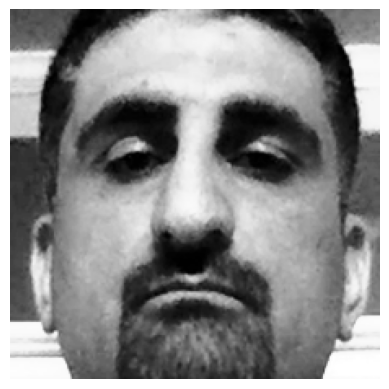

In [33]:
#read raw/preprocessed image
raw_D_IMAGE_PATH = 'data/raw/drowsy.png'
raw_D_IMAGE = cv2.imread(raw_D_IMAGE_PATH)
D_IMAGE_PATH = 'data/preprocess/drowsy.png'
D_IMAGE = cv2.imread(D_IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

# display original image
plt.axis('off')  # Hide axes
plt.imshow(cv2.cvtColor(D_IMAGE, cv2.COLOR_BGR2RGB))

Next, we will load in a non-drowsy person raw and preprocessed image.

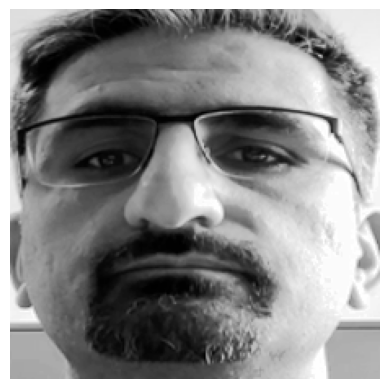

In [34]:
#read image
raw_ND_IMAGE_PATH = 'data/raw/non_drowsy.png'
raw_ND_IMAGE = cv2.imread(raw_ND_IMAGE_PATH)
ND_IMAGE_PATH = 'data/preprocess/non_drowsy.png'
ND_IMAGE = cv2.imread(ND_IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

# display original image
plt.axis('off')  # Hide axes
plt.imshow(cv2.cvtColor(ND_IMAGE, cv2.COLOR_BGR2RGB))

## Algorithm Steps


![Algorithm Steps](https://github.com/FranciscoLozCoding/csc481_Project/blob/main/images/alg2_steps.png?raw=1)

## Facial Landmark Detection

To do drowsiness detection, we first need to detect facial landmarks. In our case, the driver's eyes. We will use dlib's pre-trained face detector on the preprocessed images which is a implementation of [One Millisecond Face Alignment with an Ensemble of Regression Trees](https://www.semanticscholar.org/paper/One-millisecond-face-alignment-with-an-ensemble-of-Kazemi-Sullivan/d78b6a5b0dcaa81b1faea5fb0000045a62513567?p2df) paper by Kazemi and Sullivan (2014).

In [35]:
# init dlib's face detector
detector = dlib.get_frontal_face_detector()

#create the predictor using dlib's pretrained facial landmark detector
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")

In [36]:
# detect faces in the preprocessed image
rects = detector(D_IMAGE, 1)
image_copy = raw_D_IMAGE.copy()

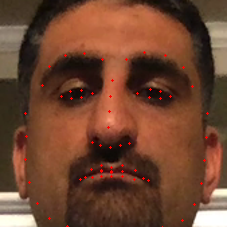

In [37]:
# loop over the face detections
for (i, rect) in enumerate(rects):
	# determine the facial landmarks for the face region, then
	# convert to a NumPy array
	shape = predictor(D_IMAGE, rect)
	shape = face_utils.shape_to_np(shape)

	# draw (x, y)- facial landmark coordinates on the image
	for (x, y) in shape:
		cv2.circle(image_copy, (x, y), 1, (0, 0, 255), -1)

# show the output image with the facial landmarks
cv2_imshow(image_copy)

Using dlib's pre-trained face detector, we successfully detected facial landmarks on our raw images by running the detector on our preprocessed images. Since our main focus is on detecting drowsiness through eye movements, our next step will be to extract the facial landmarks around the eyes specifically. We can do this by grabing the features with the indexes around the eye shown in this image.

![Facial Landmark Indexes](https://github.com/FranciscoLozCoding/csc481_Project/blob/main/images/facial_landmarks_index.png?raw=1)

In [38]:
# grab the indexes of left and right eye
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

Once, we have the indexes we can extract the eye facial landmark and see if the eye is closed or nearly closed to indicate drowsiness.

## Drowsiness Detection

First, we will set up our Hyper parameters. Padding is for how much padding in pixels should be applied around the eye. Eyelid coverage threshold is for determing if someone is drowsy or not based on the eyelid coverage. Finally, Ksize is for the cluster size in the soble filter.

We will set up a minimum eyelid coverage threshold to indicate if a driver is drowsy. Once that is set up we can calcuate how much of the driver's pupil is covered by the eyelid using the extracted eye facial landmark and a soble filter that finds the eyelid to compare it to the threshold to see if the driver is drowsy.

In [39]:
# Parameters
EYELID_COVERAGE_THRESHOLD = 0.55
PADDING = 10
KSIZE = 7

### Drowsy

We wil try our algorithm on a drowsy person first.

Eyelid coverage: 0.7456896551724138
Drowsy


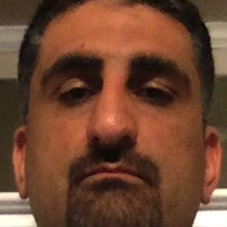

In [40]:
# Detect faces
rects = detector(D_IMAGE, 1)
image_copy = raw_D_IMAGE.copy()

for rect in rects:
  # Get the facial landmarks
  shape = predictor(D_IMAGE, rect)
  shape = face_utils.shape_to_np(shape)

  # Extract left and right eye regions
  (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
  (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
  leftEye = shape[lStart:lEnd]
  rightEye = shape[rStart:rEnd]

  # Define bounding box around the eye region
  left_eye_rect = add_eye_padding(leftEye, PADDING, image_copy)
  right_eye_rect = add_eye_padding(rightEye, PADDING, image_copy)

  # Crop eye regions from grayscale image
  left_eye_img = D_IMAGE[left_eye_rect[1]:left_eye_rect[1] + left_eye_rect[3],
                      left_eye_rect[0]:left_eye_rect[0] + left_eye_rect[2]]
  right_eye_img = D_IMAGE[right_eye_rect[1]:right_eye_rect[1] + right_eye_rect[3],
                        right_eye_rect[0]:right_eye_rect[0] + right_eye_rect[2]]

  # Detect eyelid contours using the function
  contours_left = detect_eyelid_contours(left_eye_img)
  contours_right = detect_eyelid_contours(right_eye_img)

  # Adjust contours to match original image coordinates
  contours_left = [
      [point[0][0] + left_eye_rect[0], point[0][1] + left_eye_rect[1]] for contour in contours_left for point in contour
  ]
  contours_right = [
      [point[0][0] + right_eye_rect[0], point[0][1] + right_eye_rect[1]] for contour in contours_right for point in contour
  ]

  # Calculate eyelid coverage
  left_eyelid_coverage = calculate_eyelid_coverage_from_contours(leftEye, contours_left)
  right_eyelid_coverage = calculate_eyelid_coverage_from_contours(rightEye, contours_right)
  avg_eyelid_coverage = (left_eyelid_coverage + right_eyelid_coverage) / 2

  print("Eyelid coverage:", avg_eyelid_coverage)

  # Test drowsiness based on eyelid coverage
  if avg_eyelid_coverage > EYELID_COVERAGE_THRESHOLD:
      print("Drowsy")
  else:
      print("Not Drowsy")

# Display the image with the drowsiness label
cv2_imshow(image_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

The algorithm was able to detect drowsiness succesfully

In [41]:
# Load the image in grayscale
image = left_eye_img

# Apply the Sobel operator to find the gradients in both x and y directions
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Gradient in the x-direction
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Gradient in the y-direction

# Combine the x and y gradients to get the edge magnitude
sobel_edges = cv2.magnitude(sobel_x, sobel_y)

# Convert to an 8-bit image for better visualization
sobel_edges = cv2.convertScaleAbs(sobel_edges)

# Threshold the edges to create a binary image
_, binary_edges = cv2.threshold(sobel_edges, 50, 255, cv2.THRESH_BINARY)

# Optional: Find contours in the binary image
contours, hierarchy = cv2.findContours(binary_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image (or a copy)
image_copy = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert grayscale to color
cv2.drawContours(image_copy, contours, -1, (0, 0, 255), 2)

# Display the result
cv2_imshow(image_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

You can see from this image that the entire eye is cropped out and the contour found based on the Sobel filter succesfully grabs the top of the eyelid. This will be used in comnination with the facial landmarks to measure the eyelid coverage.

### Non-Drowsy

Now we will try on a non drowsy person.

Eyelid coverage: 0.7539285714285715
Drowsy


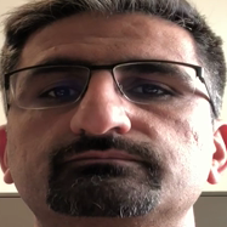

In [42]:
# Detect faces
rects = detector(ND_IMAGE, 1)
image_copy = raw_ND_IMAGE.copy()

for rect in rects:
  # Get the facial landmarks
  shape = predictor(ND_IMAGE, rect)
  shape = face_utils.shape_to_np(shape)

  # Extract left and right eye regions
  (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
  (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
  leftEye = shape[lStart:lEnd]
  rightEye = shape[rStart:rEnd]

  # Define bounding box around the eye region
  left_eye_rect = add_eye_padding(leftEye, PADDING, image_copy)
  right_eye_rect = add_eye_padding(rightEye, PADDING, image_copy)

  # Crop eye regions from grayscale image
  left_eye_img = ND_IMAGE[left_eye_rect[1]:left_eye_rect[1] + left_eye_rect[3],
                      left_eye_rect[0]:left_eye_rect[0] + left_eye_rect[2]]
  right_eye_img = ND_IMAGE[right_eye_rect[1]:right_eye_rect[1] + right_eye_rect[3],
                        right_eye_rect[0]:right_eye_rect[0] + right_eye_rect[2]]

  # Adjust leftEye and rightEye coordinates to be relative to the cropped image
  # leftEye = [(point[0] - left_eye_rect[0], point[1] - left_eye_rect[1]) for point in leftEye]
  # rightEye = [(point[0] - right_eye_rect[0], point[1] - right_eye_rect[1]) for point in rightEye]

  # Detect eyelid contours using the function
  contours_left = detect_eyelid_contours(left_eye_img)
  contours_right = detect_eyelid_contours(right_eye_img)

  # Adjust contours to match original image coordinates
  contours_left = [
      [point[0][0] + left_eye_rect[0], point[0][1] + left_eye_rect[1]] for contour in contours_left for point in contour
  ]
  contours_right = [
      [point[0][0] + right_eye_rect[0], point[0][1] + right_eye_rect[1]] for contour in contours_right for point in contour
  ]

  # Calculate eyelid coverage
  left_eyelid_coverage = calculate_eyelid_coverage_from_contours(leftEye, contours_left)
  right_eyelid_coverage = calculate_eyelid_coverage_from_contours(rightEye, contours_right)
  avg_eyelid_coverage = (left_eyelid_coverage + right_eyelid_coverage) / 2

  print("Eyelid coverage:", avg_eyelid_coverage)

  # Test drowsiness based on eyelid coverage
  if avg_eyelid_coverage > EYELID_COVERAGE_THRESHOLD:
      print("Drowsy")
  else:
      print("Not Drowsy")


# Display the image with the drowsiness label
cv2_imshow(image_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

This time the algorithm was not able to classify the driver correctly.

## Evaluation

We will run the algorithm on 20% of the dataset to see how it performs.

In [43]:
#download the processed dataset
path = kagglehub.dataset_download("franciscolozdatasci/csc481-project-dataset")
path = path + "/content/dd_dataset"
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/franciscolozdatasci/csc481-project-dataset/versions/2/content/dd_dataset


Set up our parameters again, so we can test different params.

In [44]:
# Parameters
EYELID_COVERAGE_THRESHOLD = 0.55
PADDING = 5
KSIZE = 7

In [46]:
# Paths to dataset directories
drowsy_path = os.path.join(path, "Drowsy")
non_drowsy_path = os.path.join(path, "Non Drowsy")

# Arrays to store results
d_y_true = []
d_y_pred = []
nd_y_true = []
nd_y_pred = []

# Load Drowsy images and sample 20%
drowsy_images = [os.path.join(drowsy_path, img_name) for img_name in os.listdir(drowsy_path)]
drowsy_images_sample = random.sample(drowsy_images, int(len(drowsy_images) * 0.2))

# Run detection on sampled Drowsy images, labeled as True
process_images_in_batch(drowsy_images_sample, True, d_y_true, d_y_pred, detector, predictor, PADDING, EYELID_COVERAGE_THRESHOLD, KSIZE)

# Load Non-Drowsy images and sample 20%
non_drowsy_images = [os.path.join(non_drowsy_path, img_name) for img_name in os.listdir(non_drowsy_path)]
non_drowsy_images_sample = random.sample(non_drowsy_images, int(len(non_drowsy_images) * 0.2))

# Run detection on sampled Non-Drowsy images, labeled as False
process_images_in_batch(non_drowsy_images_sample, False, nd_y_true, nd_y_pred, detector, predictor, PADDING, EYELID_COVERAGE_THRESHOLD, KSIZE)

# Combine the true and predicted labels from both categories
y_true = d_y_true + nd_y_true
y_pred = d_y_pred + nd_y_pred

Classification Report:
              precision    recall  f1-score   support

  Non-Drowsy       0.62      0.72      0.66      5889
      Drowsy       0.70      0.59      0.64      6469

    accuracy                           0.65     12358
   macro avg       0.66      0.66      0.65     12358
weighted avg       0.66      0.65      0.65     12358



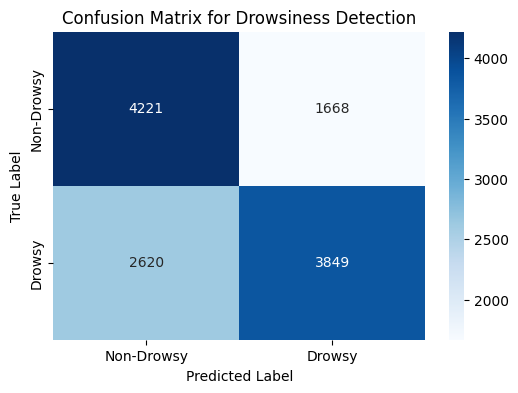

In [47]:
# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=["Non-Drowsy", "Drowsy"])

# Print the classification report
print("Classification Report:")
print(report)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Drowsy", "Drowsy"], yticklabels=["Non-Drowsy", "Drowsy"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Drowsiness Detection")
plt.show()

* The algorithm achieves an accuracy of 66%, which indicates that 66% of the time, the algorithm correctly distinguishes between drowsy and non-drowsy states.

* The algorithm is slightly better at identifying actual drowsy instances than non-drowsy ones. Based on a precision for detecting "Drowsy" at 0.70 while a 0.62 for "Non-Drowsy"

* The recall for "Non-Drowsy" is 0.72, indicating it correctly identifies 72% of actual non-drowsy cases, while the recall for "Drowsy" is 0.59, meaning that it identifies 59% of true drowsy cases. This indicates the algorithm tends to miss some drowsy instances.

* Both classes have similar F1-scores (0.67 for "Non-Drowsy" and 0.64 for "Drowsy"), showing a relatively balanced trade-off between precision and recall across both classes.

* The macro average and weighted average metrics are consistent with the overall accuracy, reflecting balanced performance across classes, with each averaging around 66%.

## My Findings

Including the eyelid in identifying drowsiness improved the drowsiness detection. The system is still not as great receiving an accuracy score of 0.65. Although, this can be improved even further by using other body languages such as head bending.